<span style="font-size:30px;">Packages</span>

In [5]:
from dask.distributed import Client
from glob import glob
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import cartopy.mpl.ticker as cticker
import numpy as np
from requests.auth import HTTPBasicAuth
import requests
import regionmask

<span style="font-size:30px;">Read data</span>

In [6]:
flist_control=sorted(glob('/g/data/bs94/AUS2200/coralsea-sstobs/v1-0/10min/pralsprof/pralsprof_AUS2200_flood22-coralsea-control_subhr_2022*.nc'))
flist_exp=sorted(glob('/g/data/bs94/AUS2200/coralsea-sstreduced/v1-0/10min/pralsprof/pralsprof_AUS2200_flood22-reducedsst_subhr_2022*.nc'))
flist_imerg=sorted(glob('/g/data/ia39/aus-ref-clim-data-nci/gpm/data/V07/2022/3B-HHR.MS.MRG.3IMERG.2022*.nc'))

In [7]:
client=Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41051 instead
  warnings.warn(


<span style="font-size:30px;">Analysis</span>

In [8]:
ds_control = xr.open_mfdataset(flist_control,parallel=True,preprocess=lambda x: x['pralsprof'])
ds_exp = xr.open_mfdataset(flist_exp,parallel=True,preprocess=lambda x: x['pralsprof'])
ds_imerg = xr.open_mfdataset(flist_imerg,parallel=True,preprocess=lambda x: x['precipitation'])

In [9]:
precip_control = ds_control['pralsprof']
precip_exp = ds_exp['pralsprof']
precip_imerg = ds_imerg['precipitation']

In [10]:
precip_imerg=precip_imerg.sel(time=slice('2022-02-21T23:00:00.000000000','2022-03-02T23:00:00.000000000'))
precip_control=precip_control.sel(time=slice('2022-02-21T23:00:00.000000000','2022-03-02T23:00:00.000000000'))
precip_exp=precip_exp.sel(time=slice('2022-02-21T23:00:00.000000000','2022-03-02T23:00:00.000000000'))

In [11]:
EAust_precip_imerg=precip_imerg.sel(lat=slice(-30,-25), lon=slice(150,159))
EAust_precip_control=precip_control.sel(lat=slice(-30,-25), lon=slice(150,159))
EAust_precip_exp=precip_exp.sel(lat=slice(-30,-25), lon=slice(150,159))

In [12]:
if EAust_precip_imerg.dims == ('lon', 'lat'):
    EAust_precip_imerg = EAust_precip_imerg.transpose('lat', 'lon')

In [13]:
EAust_precip_control_interp = EAust_precip_control.interp(lon=EAust_precip_imerg['lon'], lat=EAust_precip_imerg['lat'])
EAust_precip_exp_interp = EAust_precip_exp.interp(lon=EAust_precip_imerg['lon'], lat=EAust_precip_imerg['lat'])

In [14]:
EAust_precip_accum_control=EAust_precip_control_interp.sum(dim='lat')
EAust_precip_gridsum_control=EAust_precip_accum_control.sum(dim='lon')
EAust_precip_accum_exp=EAust_precip_exp_interp.sum(dim='lat')
EAust_precip_gridsum_exp=EAust_precip_accum_exp.sum(dim='lon')
EAust_precip_accum_imerg=EAust_precip_imerg.sum(dim='lat')
EAust_precip_gridsum_imerg=EAust_precip_accum_imerg.sum(dim='lon')

In [15]:
EAust_precip_gridsum_control = EAust_precip_gridsum_control.resample(time='1h').sum()
EAust_precip_gridsum_exp = EAust_precip_gridsum_exp.resample(time='1h').sum()
EAust_precip_gridsum_imerg = EAust_precip_gridsum_imerg.resample(time='1h').sum()

<span style="font-size:30px;">Plots</span>

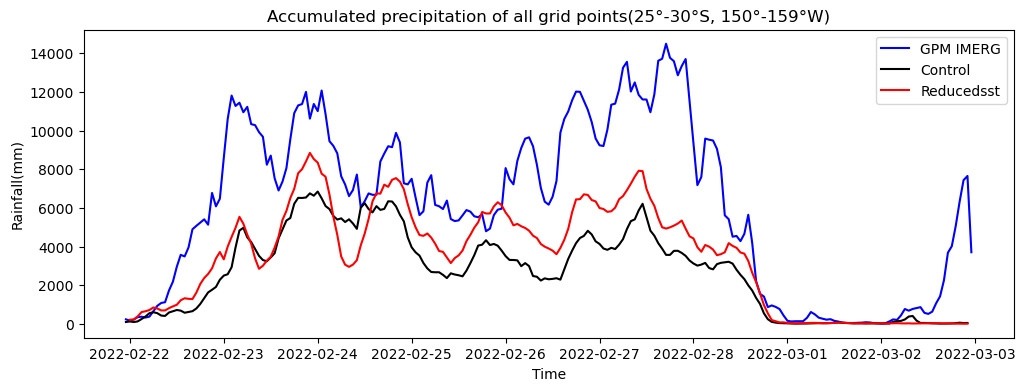

In [17]:
# timeseries
fig = plt.figure(figsize=(12, 4))
ax = plt.axes()
ax.plot(EAust_precip_gridsum_imerg['time'], EAust_precip_gridsum_imerg, c='b', linewidth=1.5)
ax.plot(EAust_precip_gridsum_control['time'], EAust_precip_gridsum_control, c='k', linewidth=1.5)
ax.plot(EAust_precip_gridsum_exp['time'], EAust_precip_gridsum_exp, c='r', linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Rainfall(mm)')
plt.legend(['GPM IMERG', 'Control', 'Reducedsst'])
ax.set_title('Accumulated precipitation of all grid points(25°-30°S, 150°-159°W)')
plt.show()

In [18]:
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
mask = land.mask(EAust_precip_imerg)
EAust_precip_imerg_land = EAust_precip_imerg.where(~mask.isnull())
mask = land.mask(EAust_precip_control)
EAust_precip_control_land = EAust_precip_control.where(~mask.isnull())
mask = land.mask(EAust_precip_exp)
EAust_precip_exp_land = EAust_precip_exp.where(~mask.isnull())

In [19]:
EAust_precip_control_interp_land = EAust_precip_control_land.interp(lon=EAust_precip_imerg['lon'], lat=EAust_precip_imerg['lat'])
EAust_precip_exp_interp_land = EAust_precip_exp_land.interp(lon=EAust_precip_imerg['lon'], lat=EAust_precip_imerg['lat'])

In [20]:
EAust_precip_accum_control_land = EAust_precip_control_interp_land.sum(dim='lat')
EAust_precip_gridsum_control_land = EAust_precip_accum_control_land.sum(dim='lon')
EAust_precip_accum_exp_land = EAust_precip_exp_interp_land.sum(dim='lat')
EAust_precip_gridsum_exp_land = EAust_precip_accum_exp_land.sum(dim='lon')
EAust_precip_accum_imerg_land = EAust_precip_imerg_land.sum(dim='lat')
EAust_precip_gridsum_imerg_land = EAust_precip_accum_imerg_land.sum(dim='lon')

In [21]:
EAust_precip_gridsum_control_land = EAust_precip_gridsum_control_land.resample(time='1h').sum()
EAust_precip_gridsum_exp_land = EAust_precip_gridsum_exp_land.resample(time='1h').sum()
EAust_precip_gridsum_imerg_land = EAust_precip_gridsum_imerg_land.resample(time='1h').sum()

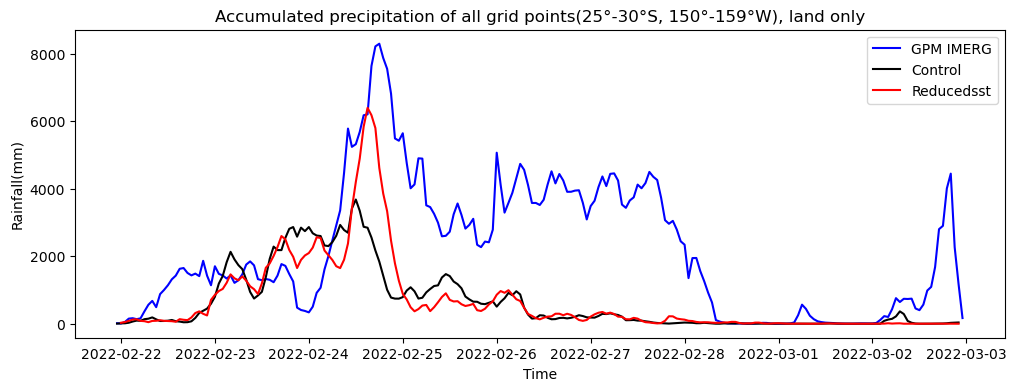

In [22]:
# timeseries land only
fig = plt.figure(figsize=(12, 4))
ax = plt.axes()
ax.plot(EAust_precip_gridsum_imerg_land['time'], EAust_precip_gridsum_imerg_land, c='b', linewidth=1.5)
ax.plot(EAust_precip_gridsum_control_land['time'], EAust_precip_gridsum_control_land, c='k', linewidth=1.5)
ax.plot(EAust_precip_gridsum_exp_land['time'], EAust_precip_gridsum_exp_land, c='r', linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Rainfall(mm)')
plt.legend(['GPM IMERG', 'Control', 'Reducedsst'])
ax.set_title('Accumulated precipitation of all grid points(25°-30°S, 150°-159°W), land only')
plt.show()

In [23]:
EAust_precip_gridsum_control_ocean = EAust_precip_gridsum_control - EAust_precip_gridsum_control_land
EAust_precip_gridsum_exp_ocean = EAust_precip_gridsum_exp - EAust_precip_gridsum_exp_land
EAust_precip_gridsum_imerg_ocean = EAust_precip_gridsum_imerg - EAust_precip_gridsum_imerg_land

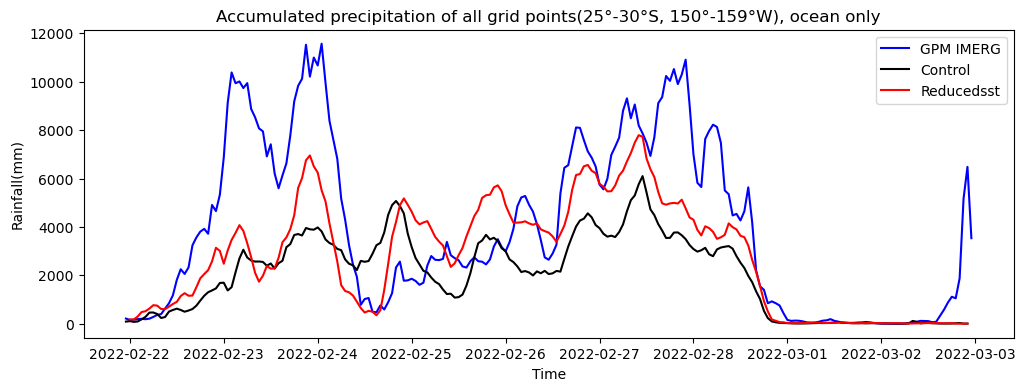

In [24]:
# timeseries ocean only
fig = plt.figure(figsize=(12, 4))
ax = plt.axes()
ax.plot(EAust_precip_gridsum_imerg_ocean['time'], EAust_precip_gridsum_imerg_ocean, c='b', linewidth=1.5)
ax.plot(EAust_precip_gridsum_control_ocean['time'], EAust_precip_gridsum_control_ocean, c='k', linewidth=1.5)
ax.plot(EAust_precip_gridsum_exp_ocean['time'], EAust_precip_gridsum_exp_ocean, c='r', linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Rainfall(mm)')
plt.legend(['GPM IMERG', 'Control', 'Reducedsst'])
ax.set_title('Accumulated precipitation of all grid points(25°-30°S, 150°-159°W), ocean only')
plt.show()

In [25]:
EAust_precip_control2 = EAust_precip_control_interp.resample(time='1h').sum()
EAust_precip_exp2 = EAust_precip_exp_interp.resample(time='1h').sum()
EAust_precip_imerg2 = EAust_precip_imerg.resample(time='1h').sum()

EAust_precip_control_flatten = EAust_precip_control2.values.flatten()
EAust_precip_exp_flatten = EAust_precip_exp2.values.flatten()
EAust_precip_imerg_flatten = EAust_precip_imerg2.values.flatten()

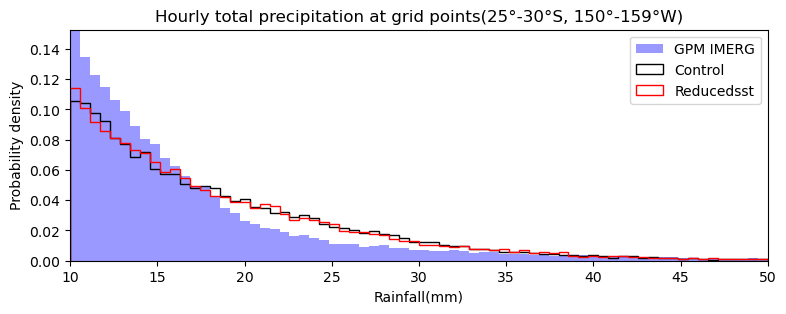

In [26]:
# histogram
fig = plt.figure(figsize=(9, 3))
ax = plt.axes()
ax.margins(0)
plt.hist(EAust_precip_imerg_flatten, bins=70, range=(10, 50), alpha=0.4, label='Reducedsst', color='blue', density=True)
plt.hist(EAust_precip_control_flatten, bins=70, range=(10, 50), histtype='step', label='Control', color='black', density=True)
plt.hist(EAust_precip_exp_flatten, bins=70, range=(10, 50), histtype='step', label='Reducedsst', color='red', density=True)
plt.xlabel('Rainfall(mm)')
plt.ylabel('Probability density')
plt.legend(['GPM IMERG', 'Control', 'Reducedsst'])
ax.set_title('Hourly total precipitation at grid points(25°-30°S, 150°-159°W)')
plt.show()